# ARIMAS Time Series
## MSDS 7333 - Section 401
## Case Study Week 4
[Data Science @ Southern Methodist University](https://datascience.smu.edu/)

### Due:
04 June 2018

### Table of Contents
* [Team Members](#Team-Members)
* [Abstract](#Abstract)
* [Introduction](#Introduction)
* [Methods](#Methods)
* [Results](#Results)
* [Conclusion](#Conclusion)

### <a name="Team-Members"></a>Team Members
* Kevin Cannon
* Austin Hancock

### <a name="Abstract"></a>Abstract
Use historical stock price data in python to analyze time series data with ARIMAS. Estimate ARIMAS model parameters (p,d,q) using autocorrelation functions and rule-based decision making, and compare the results to a grid search for the parameters.

### <a name="Introduction"></a>Introduction
A time series is a data set that has values listed in time order. Time series analysis consists of various methods to glean meaningful statistics from the data, including the random walk, autoregressive (AR), moving average (MA), and the autoregressive integrated moving average (ARIMA) models. All of these models 
are based on a linear function of the preceding values and noise. These models impose a constraint of linearity on the function that generates the time series data.

The ARIMA model can be used to better understand the data or to forecast future values when the data shows evidence of non-stationarity. A stationary time series is a series of values whose mean, variance, autocorrelation, and other statistical properties remain constant over time. 

In this lab, we will be using historical stock price data as our starting time series. Since stock prices can fluctuate greatly and do not necessarily depend on seasonal trends, the data will likely not be stationary. Fortunately, the ARIMA model assumes that the data can be made stationary through the use of mathematical transformations.

For the stock prices, we will transform the data set by differencing. Differencing is accomplished by calculating the difference between two consecutive observations in the time series. By differencing the data, we can help to stablize the mean, eliminating trends and seasonality in the time series data.

### <a name="Methods"></a>Methods
The following cells contain the methods and brief explanations.

We will we looking at the stock price for Pfizer Inc. [[NYSE: PFE]](https://finance.yahoo.com/q?s=PFE).

The goal of this case study is to estimate the ARIMA model parameters for stock price over four years. When collected, the data will contain the stock price on a given day over a four year period.

In [2]:
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt
import matplotlib 
%matplotlib inline

# import stock data for Pfizer ('PFE')
import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as web
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2018, 2, 1)
price = web.DataReader('PFE', 'iex', start, end)['close']
price.index = pd.to_datetime(price.index)

5y


Check that the data has been read in correctly.

In [3]:
price

date
2014-01-02    25.9004
2014-01-03    25.9514
2014-01-06    25.9769
2014-01-07    26.1385
2014-01-08    26.3170
2014-01-09    26.3000
2014-01-10    26.0960
2014-01-13    25.9684
2014-01-14    26.3595
2014-01-15    26.5126
2014-01-16    26.5041
2014-01-17    26.4361
2014-01-21    26.5551
2014-01-22    26.5891
2014-01-23    26.3681
2014-01-24    25.5858
2014-01-27    25.2201
2014-01-28    25.8664
2014-01-29    25.6028
2014-01-30    26.2065
2014-01-31    25.8494
2014-02-03    26.0194
2014-02-04    26.7337
2014-02-05    26.2793
2014-02-06    26.4422
2014-02-07    26.7680
2014-02-10    26.9823
2014-02-11    27.3339
2014-02-12    27.1024
2014-02-13    27.1795
               ...   
2017-12-19    36.2471
2017-12-20    35.7761
2017-12-21    35.5602
2017-12-22    35.4621
2017-12-26    35.5308
2017-12-27    35.6485
2017-12-28    35.6878
2017-12-29    35.5406
2018-01-02    35.7565
2018-01-03    36.0214
2018-01-04    36.0999
2018-01-05    36.1686
2018-01-08    35.7663
2018-01-09    35.7270
2018-

Then, plot the price data.

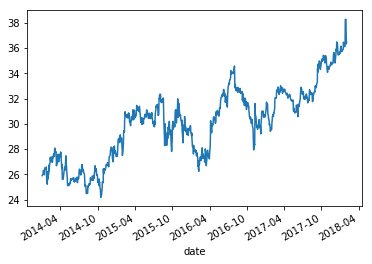

In [6]:
price.plot()

Create a function that implements the Dickey-Fuller test and plots data along with rolling mean and standard deviation.

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


Check if the stock price series is stationary using the Dickey-Fuller test.

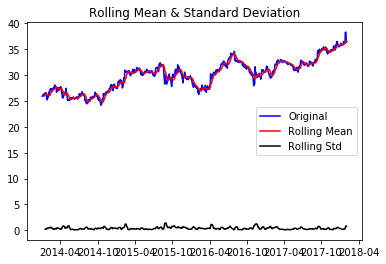

Results of Dickey-Fuller Test:
Test Statistic                   -1.073587
p-value                           0.725489
#Lags Used                        4.000000
Number of Observations Used    1024.000000
Critical Value (1%)              -3.436752
Critical Value (5%)              -2.864367
Critical Value (10%)             -2.568275
dtype: float64


In [8]:
test_stationarity(price)

> With a test statistic of -1.073587, the price series data is not stationary. The series does not even meet the 10% critical value threshold of -2.568275. We will need to make the data more stationary to use the ARIMAS model.

Next we will use differencing to try and eliminate seasonality and make the series further stationary.  This determines if we use a difference term or not.

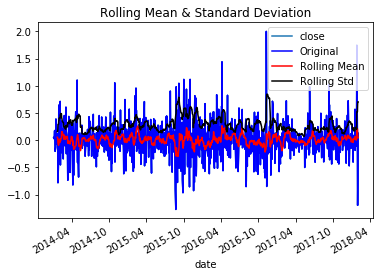

Results of Dickey-Fuller Test:
Test Statistic                -1.759398e+01
p-value                        3.951232e-30
#Lags Used                     3.000000e+00
Number of Observations Used    1.024000e+03
Critical Value (1%)           -3.436752e+00
Critical Value (5%)           -2.864367e+00
Critical Value (10%)          -2.568275e+00
dtype: float64


In [9]:
diff=price-price.shift()
diff.dropna(inplace=True)
diff.plot()
test_stationarity(diff)

> From the plot, the differencing appears to have created a stationary series. The test statistic from the Dickey-Fuller test is an order of magnitude more negative than even the 1% critical value threshold, confirming that the series with the differencing is in fact stationary.

Now that we have a stationary series, we can take a look at the correlation functions. From this point forward, we will use the stationary data set after differencing was applied for ease of analysis. We will look at the plots of the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF).

Text(0.5,1,'Autocorrelation Function')

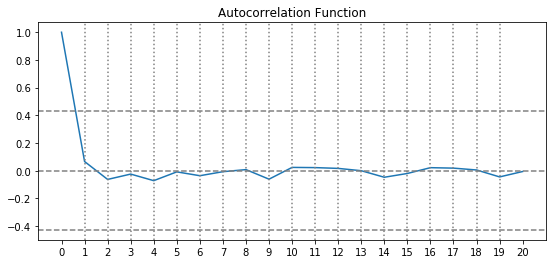

In [10]:
from statsmodels.tsa.stattools import acf, pacf

acf_air_plot = acf(diff, nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function')

> The plot of the Autocorrelation function,the autocorrelations are small and patternless. Based on the plot, the series does not need a higher order of differencing. A model with no differencing assmes that the data series is stationary, which matches the results of the Dickey-Fuller test performed on this data series.

> As for the ARIMA model, since the series is not overdifferenced, there will be no need for an additional 'd' term in our final model.

> However, by Rule 7, the series does display a sharp cutoff prior to lag-1, therefore, a term may be added to the MA model. The value q may be q=0 or q=1.

Text(0.5,1,'Partial Autocorrelation Function')

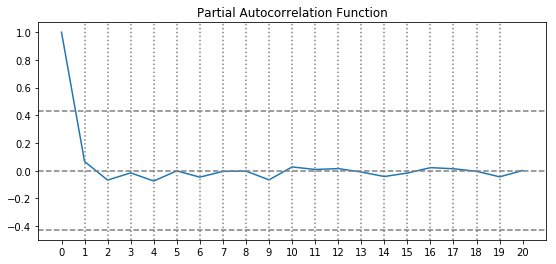

In [11]:
pacf_air_plot = pacf(diff, nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(pacf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Partial Autocorrelation Function')

> The Partial Autocorrelation Function displays nearly the same behavior as ACF. The plot drops immediately and has a value around zero just after the first lag. The autocorrelations are small and patternless. Based on the plot, the series does not need a higher order of differencing.

> As for the ARIMA model, since the series is not overdifferenced, there will be no need for an additional 'd' term in our final model.

> However, by Rule 6, the series does have a slightly positive autocorrelation at lag-1, therefore, a term may be added to the AR model. The value p may be p=0 or p=1.

> With both p & q having possible values of 1, that leaves 4 combinations of [p,d,q] to try for the ARIMA model: [1,0,1], [0,0,0], [1,0,0], and [0,0,1]. However, from trial and error, both [1,0,1] and [0,0,0] produce errors. 

> Based on the two autocorrelation functions, the ARIMA model will likely perform best using a [0,0,1] or [1,0,0] model based on our rules.

Now we fit a model of the proper order and look at the output. We attempted to look at both the [0,0,1], the MA(1) model, and [1,0,0], the AR(1) model.

C:\Users\KCannon\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\KCannon\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\KCannon\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                 1028
Model:                     ARMA(0, 1)   Log Likelihood                -279.429
Method:                       css-mle   S.D. of innovations              0.318
Date:                Sun, 03 Jun 2018   AIC                            564.858
Time:                        10:04:24   BIC                            579.664
Sample:                    01-03-2014   HQIC                           570.477
                         - 02-01-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0103      0.011      0.967      0.334      -0.011       0.031
ma.L1.close     0.0759      0.033      2.290      0.022       0.011       0.141
                                    Roots       

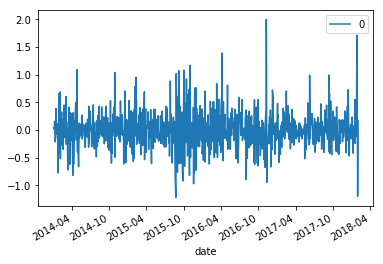

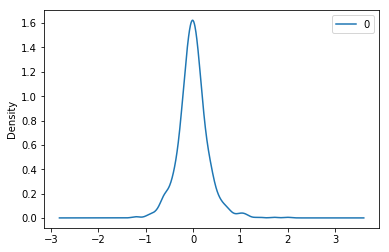

                 0
count  1028.000000
mean     -0.000003
std       0.317703
min      -1.216339
25%      -0.169310
50%      -0.011636
75%       0.150423
max       1.999644


In [17]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(diff, order=(0,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

C:\Users\KCannon\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\KCannon\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\KCannon\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                 1028
Model:                     ARMA(1, 0)   Log Likelihood                -279.762
Method:                       css-mle   S.D. of innovations              0.318
Date:                Sun, 03 Jun 2018   AIC                            565.525
Time:                        10:07:52   BIC                            580.331
Sample:                    01-03-2014   HQIC                           571.144
                         - 02-01-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0103      0.011      0.971      0.332      -0.010       0.031
ar.L1.close     0.0662      0.031      2.130      0.033       0.005       0.127
                                    Roots       

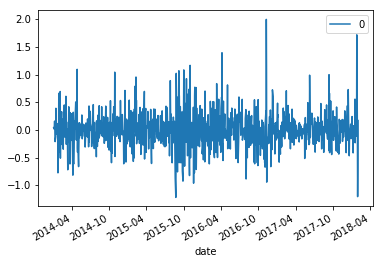

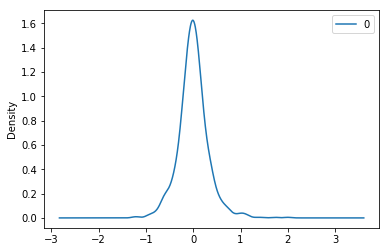

                 0
count  1028.000000
mean     -0.000003
std       0.317807
min      -1.221535
25%      -0.169066
50%      -0.011573
75%       0.151167
max       1.996894


In [20]:
model = ARIMA(diff, order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

> Both the AR(1) and the MA(1) models produce nearly identical results.

Now, we will conduct a brute force grid search for the best parameters.

10.2071670519751


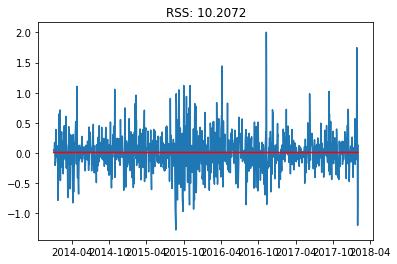

0 0 0
10.18139284954139


C:\Users\KCannon\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\KCannon\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\KCannon\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


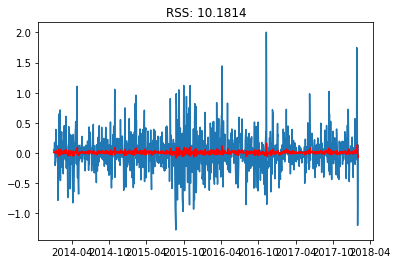

0 0 1
10.158970294804742


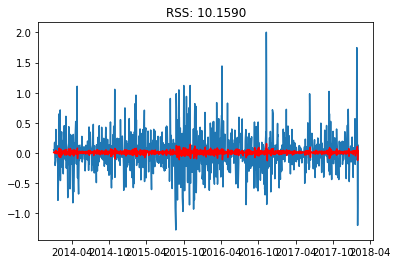

0 0 2


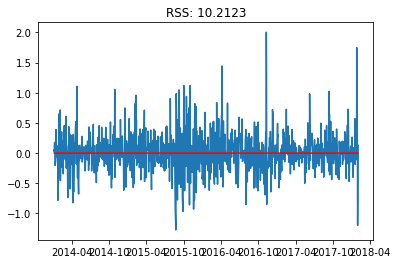

0 1 0


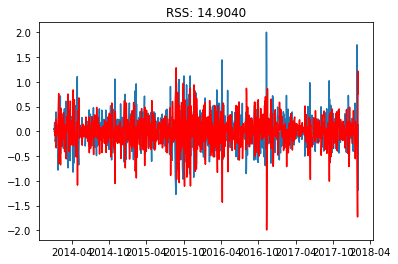

0 1 1


C:\Users\KCannon\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


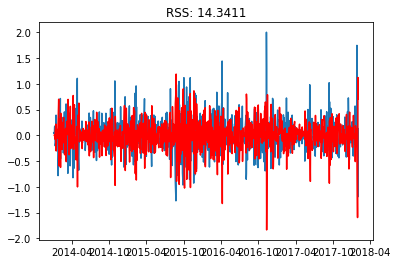

0 1 2


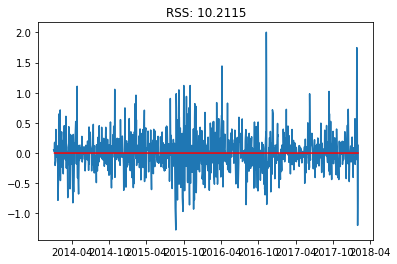

0 2 0


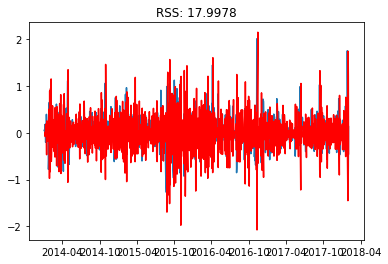

0 2 1


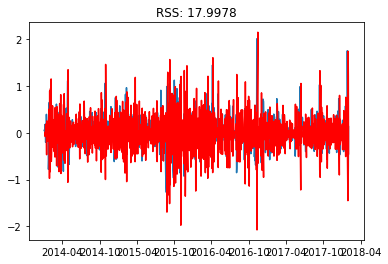

0 2 2


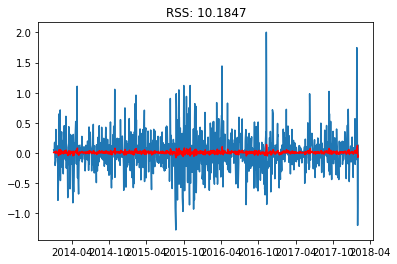

1 0 0


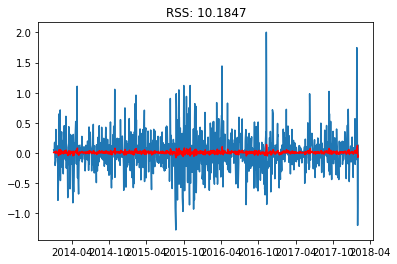

1 0 1


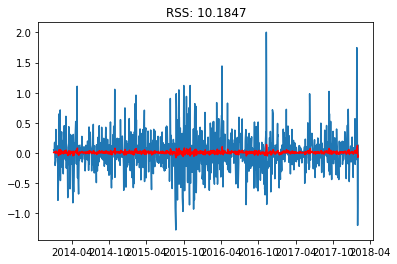

1 0 2


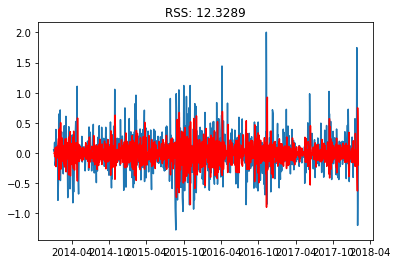

1 1 0


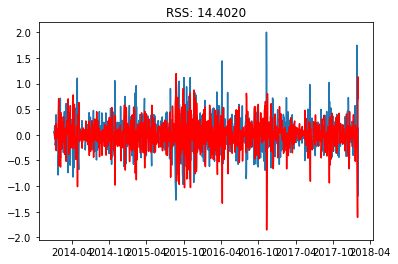

1 1 1


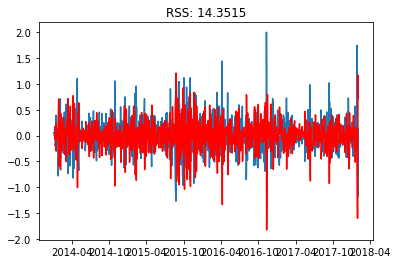

1 1 2


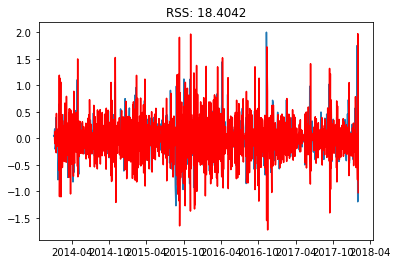

1 2 0


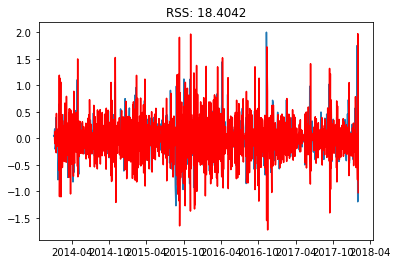

1 2 1


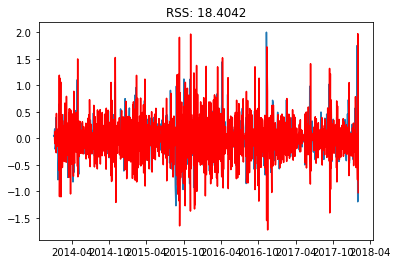

1 2 2


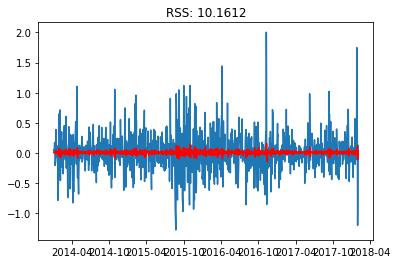

2 0 0
10.137549652029751


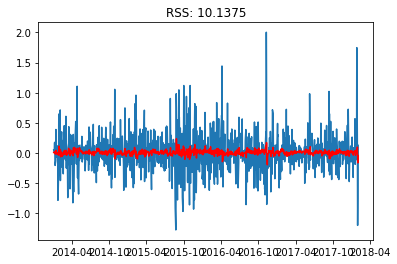

2 0 1
10.130899913909543


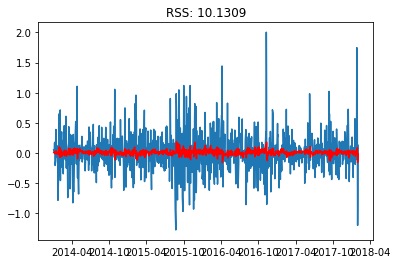

2 0 2


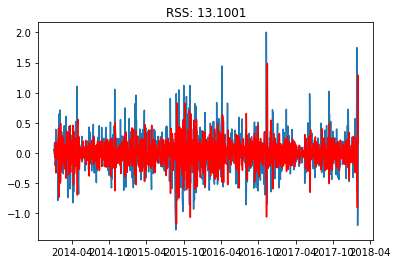

2 1 0


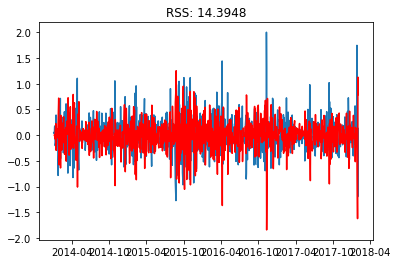

2 1 1


C:\Users\KCannon\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


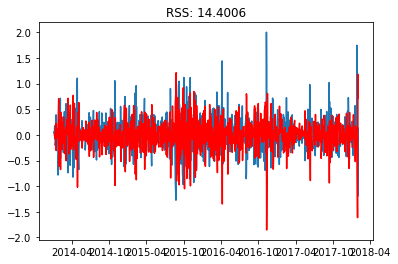

2 1 2


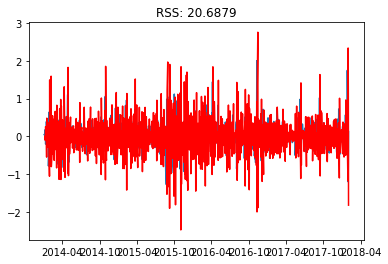

2 2 0


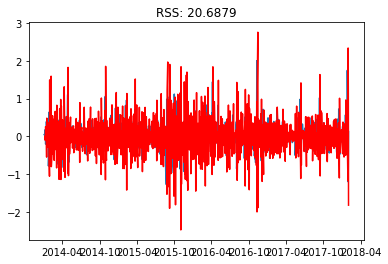

2 2 1


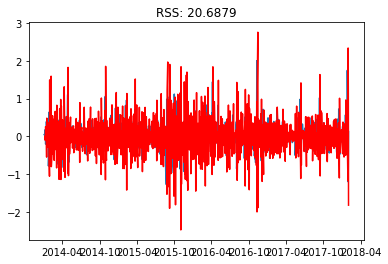

2 2 2


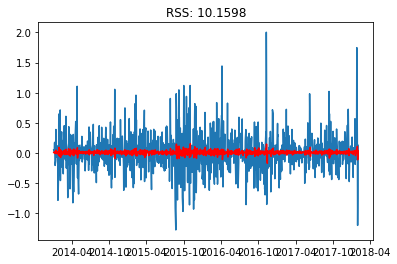

3 0 0


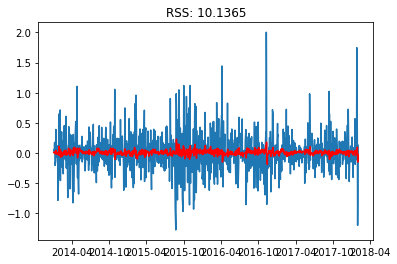

3 0 1
10.127114888959252


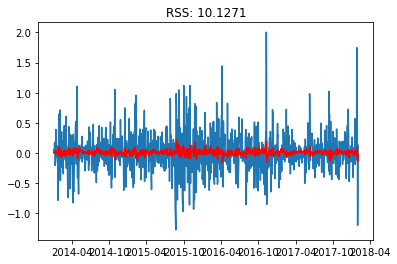

3 0 2


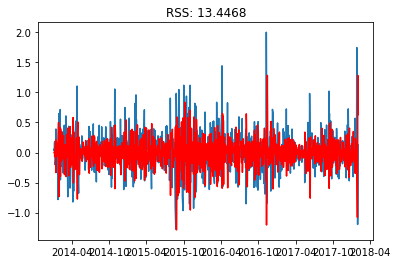

3 1 0


C:\Users\KCannon\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


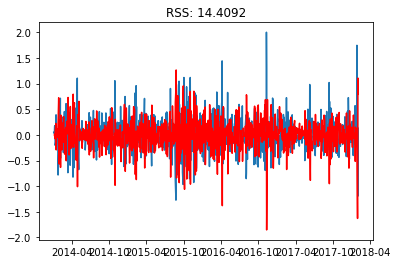

3 1 1


C:\Users\KCannon\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\KCannon\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


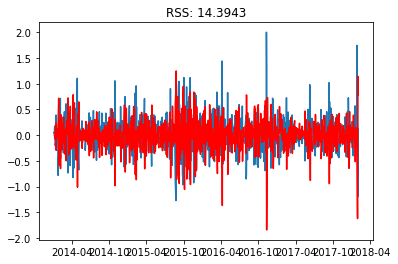

3 1 2


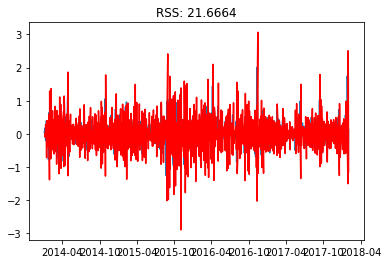

3 2 0


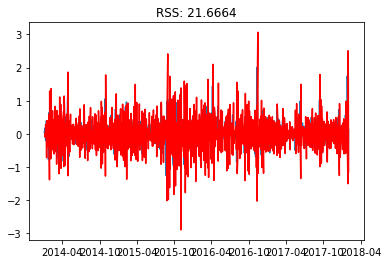

3 2 1


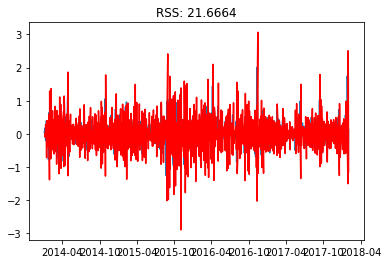

3 2 2


In [21]:
loss_best = 1E16
best_ints = [-1,-1,-1]
for p in range(4):
    for d in range(3):
        for q in range(3):
            model = ARIMA(diff, order=(p, d, q))  
            try:
                results_ARIMA = model.fit(disp=-1)
            except ValueError:
                pass
            except:
                pass
            plt.plot(diff)
            plt.plot(results_ARIMA.fittedvalues, color='red')
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            x=x.join(diff)
            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            plt.title('RSS: %.4f'% loss)
            if loss < loss_best:
                print(loss)
                loss_best = loss
                best_ints=[p,d,q]
            plt.show()
            print(p,d,q)

In [27]:
print(loss_best)
print(best_ints)

10.127114888959252
[3, 0, 2]


From the grid search, the RSS values of interest are summarized in the table below:

Values of interest:

| [p, d, q]   | RSS     | 
| :-------:   |:------: |
| [0, 0, 0]   | 10.207  |
| [0, 0, 1]   | 10.181  |
| [0, 0, 2]   | 10.158  |
| [1, 0, 0]   | 10.184  |
| [1, 0, 1]   | 10.184  |
| [2, 0, 0]   | 10.161  |
| [2, 0, 1]   | 10.137  |
| [2, 0, 2]   | 10.130  |
| [3, 0, 0]   | 10.136  |
| [3, 0, 2]   | 10.127* | 
*Best RSS according to loss_best

With such a small variation between the RSS values, there appears to be no difference between the models with many different parameters and models with few or no parameters.

### <a name="Results"></a>Results
Based on the results of the grid search, adding additional complexity by adding parameters to the model provides a negligible improvement in RSS. Therefore, with only marginal improvement, an argument could be made that a simpler model will suffice over a more complex model.

From the parameter evaluations using the two autocorrelation functions, we estimated that the ARIMA model would likely perform best using a [0,0,1] or [1,0,0] model based on our rules. Since, according to RSS, the [0,0,1] model performs ever so slightly better than the [1,0,0], we will choose the [0,0,1] model.

To recap, the best fit for the final parameters of the ARIMA model of the differenced stock price time series data is simply a first order moving average model, MA(1).

### <a name="Conclusion"></a>Conclusion
Based on the Rules for p & q, the best ARIMA model aligns with our initial predictions. Both the ACF and PACF display sharp declines prior to the first lag term. From Rules 6 & 7, one or more AR terms and MA terms can be added to the model. With both p & q having possible values of 1, that left 4 combinations of [p,d,q] in the ARIMA model that were of special interest: [1,0,1], [0,0,0], [1,0,0], and [0,0,1].

Then, we performed a grid search to compare various combinations of parameters, paying special attention to the previous predictions. The results of the grid search had several models of varying complexity with similar RSS values. The values of interest, which were simple models, matched results from higher order models in the grid search. In general, the higher order models performed about the same as lower order models. Therefore, in an effort to reduce unnecessary complexity from the model, the final parameters were chosen to be [p,d,q]=[0,0,1]. The final model for the differenced stock price time series data is a first order moving average model, or MA(1).